In [1]:
#standard imports
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
import tensorflow as tf
from tensorflow import keras

#import generic model class
from tensorflow.keras import Model, Input

#imports for CNN model construction
from keras.regularizers import l2
from keras.models import Sequential
from keras.utils import to_categorical
from keras.optimizers.legacy import Adam
from keras.callbacks import EarlyStopping
from sklearn.model_selection import train_test_split
from keras.preprocessing.image import  load_img, ImageDataGenerator
from keras.layers import Conv2D, MaxPooling2D, Dense, Flatten, Dropout, AvgPool2D
from sklearn.model_selection import KFold

#import for study the performance of the model
from sklearn.metrics import roc_curve, auc, confusion_matrix

#imports for confusion matrix
import seaborn as sns
sns.set(style= "darkgrid", color_codes = True)
from keras.applications import VGG16

#imports for draw the model
import graphviz
import pydot
from keras.utils import plot_model
from IPython.display import Image

#imports random
import random as rn
from random import randrange

#imports for preprocessing the data
import glob
import os
import cv2

# Fix the Seed in order to produce always the same results

In [2]:
# Define a seed value for the random operations
seed_value= 0

# 1. Set the `PYTHONHASHSEED` environment variable at a fixed value
os.environ['PYTHONHASHSEED']=str(seed_value)

# 2. Set the `python` built-in pseudo-random generator at a fixed value
rn.seed(seed_value)

# 3. Set the `numpy` pseudo-random generator at a fixed value
np.random.seed(seed_value)

# 4. Set the `tensorflow` pseudo-random generator at a fixed value
tf.random.set_seed(seed_value)

# 5. Configure a new global `tensorflow` session
session_conf = tf.compat.v1.ConfigProto(intra_op_parallelism_threads=1, inter_op_parallelism_threads=1)
sess = tf.compat.v1.Session(graph=tf.compat.v1.get_default_graph(), config=session_conf)
tf.compat.v1.keras.backend.set_session(sess)

# Data Preprocessing

In [3]:
# Define image size and other parameterst 
path_to_change = '/Users/giac/Desktop/Esame_Reti_Neurali/Progetto/'
path = path_to_change + 'chest_xray/'
dimension = 250
img_width, img_height = dimension, dimension
batchsize = 32
num_of_class = 2

train = keras. utils.image_dataset_from_directory(
    directory= path + 'train',
    labels='inferred',
    label_mode='categorical',
    batch_size=batchsize,
    image_size=(img_width, img_height))

test = keras. utils.image_dataset_from_directory(
    directory= path + 'test',
    labels='inferred',
    label_mode='categorical',
    batch_size=batchsize,
    image_size=(img_width, img_height))

Found 5216 files belonging to 2 classes.
Found 624 files belonging to 2 classes.


In [4]:
# define paths
train_normal_dir = path + 'train/NORMAL/'
train_pneu_dir = path + 'train/PNEUMONIA/'

test_normal_dir = path + 'test/NORMAL/'
test_pneu_dir = path + 'test/PNEUMONIA/'

# find all files, our files has extension jpeg
train_normal_cases = glob.glob(train_normal_dir + '*jpeg')
train_pneu_cases = glob.glob(train_pneu_dir + '*jpeg')

test_normal_cases = glob.glob(test_normal_dir + '*jpeg')
test_pneu_cases = glob.glob(test_pneu_dir + '*jpeg')

# create lists for train, test & validation cases, create labels as well
train_list = []
test_list = []
val_list = []

for x in train_normal_cases:
    train_list.append([x, 0])
    
for x in train_pneu_cases:
    train_list.append([x, 1])
    
for x in test_normal_cases:
    test_list.append([x, 0])
    
for x in test_pneu_cases:
    test_list.append([x, 1])
    
# shuffle/randomize data 
rn.shuffle(test_list)

# create dataframes
train_df = pd.DataFrame(train_list, columns=['image', 'label'])
test_df = pd.DataFrame(test_list, columns=['image', 'label'])

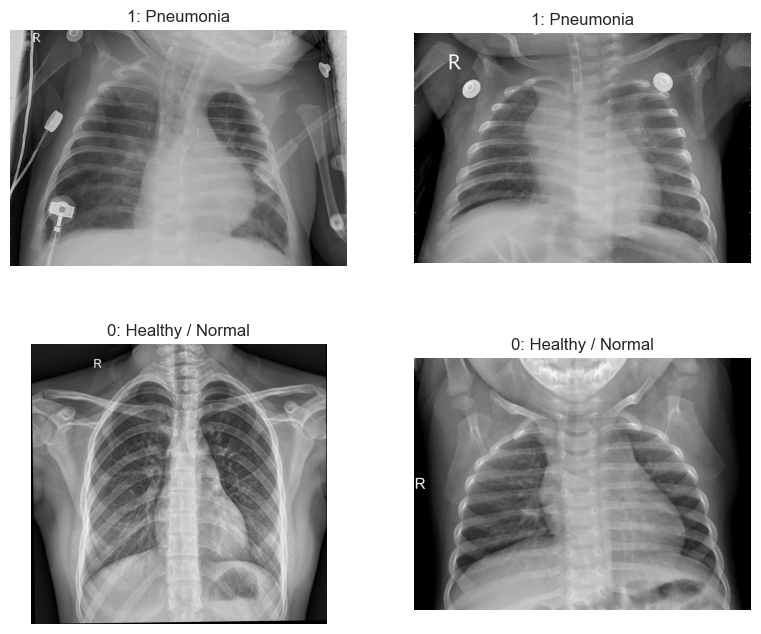

In [5]:
# Some plots before to go
plt.figure(figsize=(20,8))
for i,img_path in enumerate(train_df[train_df['label'] == 1][0:2]['image']):
    plt.subplot(2,4,i+1)
    plt.axis('off')
    img = plt.imread(img_path)
    plt.imshow(img, cmap='gray')
    plt.title('1: Pneumonia')
    
for i,img_path in enumerate(train_df[train_df['label'] == 0][0:2]['image']):
    plt.subplot(2,4,4+i+1)
    plt.axis('off')
    img = plt.imread(img_path)
    plt.imshow(img, cmap='gray')
    plt.title('0: Healthy / Normal')

In [6]:
# RESIZE
resize = 48

In [7]:
# preprocessing the data
def process_data(img_path):
    img = cv2.imread(img_path)
    img = cv2.resize(img, (resize, resize))
    img = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)
    img = img/255.0
    img = np.reshape(img, (resize,resize,1))
    
    return img

def compose_dataset(df):
    data = []
    labels = []

    for img_path, label in df.values:
        data.append(process_data(img_path))
        labels.append(label)
        
    return np.array(data), np.array(labels)

In [8]:
# compose the train and the test sets
X_train, y_train = compose_dataset(train_df)
X_test, y_test = compose_dataset(test_df)

# validation set size
val_size = .1

# generate training and test set
X_train, X_val, y_train, y_val = train_test_split(X_train, y_train, test_size=val_size, stratify=y_train)

print('Train data shape: {}, Labels shape: {}'.format(X_train.shape, y_train.shape))
print('Test data shape: {}, Labels shape: {}'.format(X_test.shape, y_test.shape))
print('Validation data shape: {}, Labels shape: {}'.format(X_val.shape, y_val.shape))

Train data shape: (4694, 48, 48, 1), Labels shape: (4694,)
Test data shape: (624, 48, 48, 1), Labels shape: (624,)
Validation data shape: (522, 48, 48, 1), Labels shape: (522,)


Text(0.5, 0, '  Normal                                           Pneumonia')

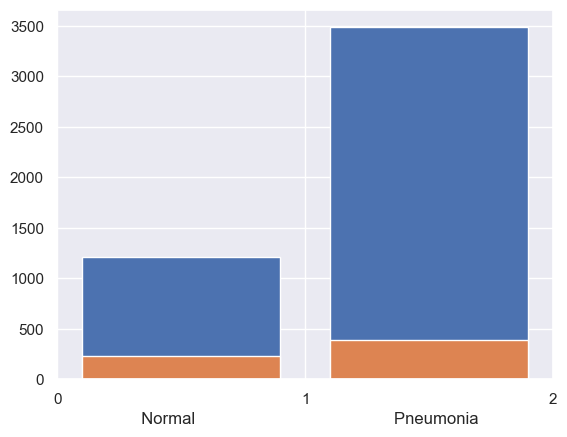

In [9]:
# distribution of data on train set
plt.hist(y_train, bins=np.linspace(0,2,3), rwidth=.8)
plt.xticks(range(3))
plt.xlabel("  Normal                                           Pneumonia")

# distribution of data on test set
plt.hist(y_test, bins=np.linspace(0,2,3), rwidth=.8)
plt.xticks(range(3))
plt.xlabel("  Normal                                           Pneumonia")

In [10]:
# define generator for data augmentation
datagen = ImageDataGenerator(
    rotation_range=10,
    zoom_range = 0.1,
    width_shift_range=0.1,
    height_shift_range=0.1,
    horizontal_flip=False,
    vertical_flip=False
)

# fit generator on our train features
datagen.fit(X_train)

# define categorical labels
y_train_cat = keras.utils.to_categorical(y_train, num_of_class)
y_test_cat = keras.utils.to_categorical(y_test, num_of_class)
y_val_cat = keras.utils.to_categorical(y_val, num_of_class)

# CNN Model Architecture 

In [11]:
# Model
model = Sequential()

model.add(Conv2D(filters=8, kernel_size=(7,7), padding='same', activation='relu', input_shape=(resize, resize, 1)))
model.add(MaxPooling2D(pool_size=(2,2)))

model.add(Conv2D(filters=16, kernel_size=(5,5), padding='same', activation='relu'))
model.add(Conv2D(filters=16, kernel_size=(5,5), padding='same', activation='relu'))
model.add(MaxPooling2D(pool_size=(2,2)))

model.add(Flatten())

model.add(Dense(128, activation='relu'))
model.add(Dropout(0.2))
model.add(Dense(128, activation='relu', kernel_regularizer=l2(0.03)))
model.add(Dropout(0.2))
model.add(Dense(2, activation='sigmoid'))

optimizer = Adam(learning_rate=0.0005, decay=1e-5)
model.compile(loss='categorical_crossentropy', optimizer=optimizer, metrics=['accuracy'])

callback = EarlyStopping(monitor='loss', patience=6)

In [12]:
model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d (Conv2D)             (None, 48, 48, 8)         400       
                                                                 
 max_pooling2d (MaxPooling2  (None, 24, 24, 8)         0         
 D)                                                              
                                                                 
 conv2d_1 (Conv2D)           (None, 24, 24, 16)        3216      
                                                                 
 conv2d_2 (Conv2D)           (None, 24, 24, 16)        6416      
                                                                 
 max_pooling2d_1 (MaxPoolin  (None, 12, 12, 16)        0         
 g2D)                                                            
                                                                 
 flatten (Flatten)           (None, 2304)              0

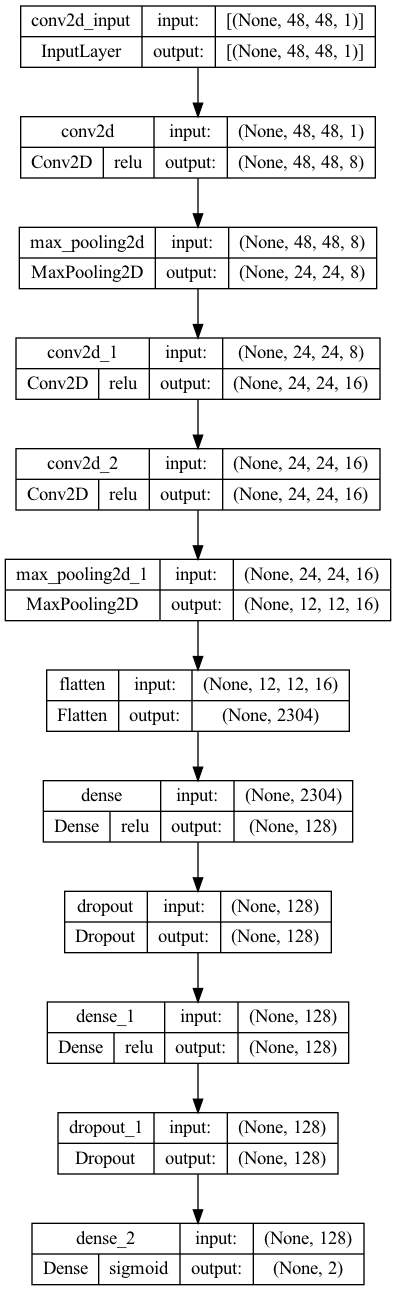

In [13]:
# CNN architecture
keras.utils.plot_model(
    model,
    to_file="model.png",
    show_shapes=True,
    show_dtype=False,
    show_layer_names=True,
    rankdir="TB",
    expand_nested=False,
    dpi=96,
    layer_range=None,
    show_layer_activations=True,
    show_trainable=False,
)


# Model Training

In [14]:
# Define some hyperparameter
epochs = 100
batch_size = 32


In [15]:
# Training
history = model.fit(
    datagen.flow(X_train, y_train_cat, batch_size=batch_size),
    validation_data=(X_val, y_val_cat),
    epochs=epochs,
    verbose=1,
    callbacks=[callback],
)

Epoch 1/100
147/147 [==============================] - 7s 48ms/step - loss: 2.5342 - accuracy: 0.7765 - val_loss: 1.1335 - val_accuracy: 0.8812
Epoch 2/100
147/147 [==============================] - 7s 47ms/step - loss: 0.7437 - accuracy: 0.8749 - val_loss: 0.3651 - val_accuracy: 0.9387
Epoch 3/100
147/147 [==============================] - 7s 47ms/step - loss: 0.3437 - accuracy: 0.9088 - val_loss: 0.1911 - val_accuracy: 0.9521
Epoch 4/100
147/147 [==============================] - 7s 47ms/step - loss: 0.2672 - accuracy: 0.9075 - val_loss: 0.1614 - val_accuracy: 0.9483
Epoch 5/100
147/147 [==============================] - 7s 47ms/step - loss: 0.2240 - accuracy: 0.9178 - val_loss: 0.1472 - val_accuracy: 0.9521
Epoch 6/100
147/147 [==============================] - 7s 47ms/step - loss: 0.2078 - accuracy: 0.9190 - val_loss: 0.1241 - val_accuracy: 0.9559
Epoch 7/100
147/147 [==============================] - 7s 47ms/step - loss: 0.1934 - accuracy: 0.9301 - val_loss: 0.1270 - val_accuracy:

# Results

In [16]:
#evaluate model on the test set
test_loss, test_acc = model.evaluate(X_test, y_test_cat)

print()
print('Test Loss = {:.3f}\t'.format(test_loss))
print('Test Accuracy = {:.3f}\t'.format(test_acc))

20/20 [==============================] - 0s 15ms/step - loss: 0.2861 - accuracy: 0.9006

Test Loss = 0.286	
Test Accuracy = 0.901	


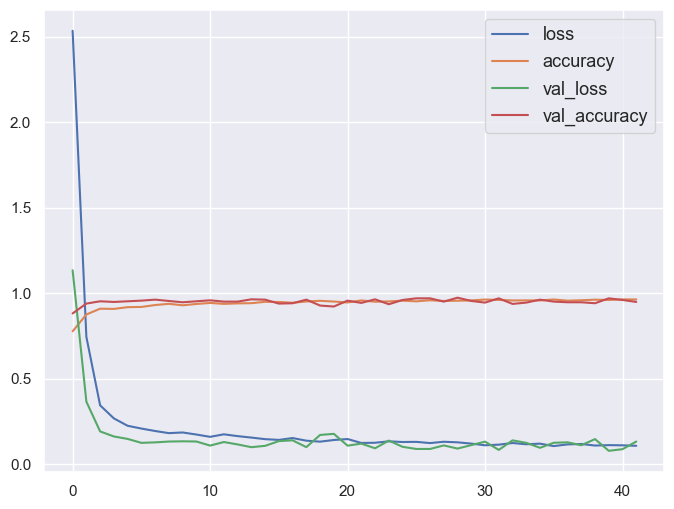

In [17]:
# plot learning curves
fig, ax = plt.subplots(figsize=(8,6))

for metric in history.history:
    
    if len(metric.split('_')) < 2:
        ax.plot(np.array(history.epoch), history.history[metric], label=metric)
    else:
        ax.plot(history.epoch, history.history[metric], label=metric)
    
ax.grid(True)    

ax.legend(fontsize=13);

In [18]:
# prediction on test set
predictions = model.predict(X_test)
predicted_labels = np.argmax(predictions, axis=1)

# compute the confusion matrix
conf_matrix = confusion_matrix(y_test, predicted_labels)

20/20 [==============================] - 0s 15ms/step


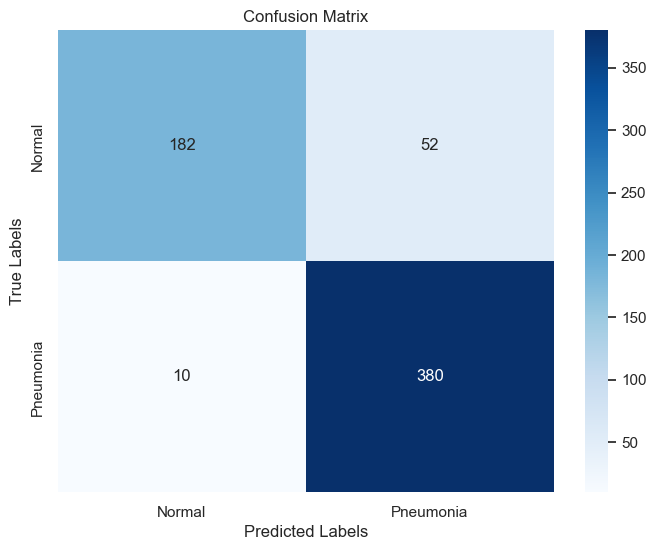

None


In [19]:
# show the confusion matrix

class_labels = ["Normal", "Pneumonia"]

plt.figure(figsize=(8, 6))
sns.heatmap(conf_matrix, annot=True, fmt='d', cmap='Blues', 
            xticklabels=class_labels, yticklabels=class_labels)
plt.xlabel('Predicted Labels')
plt.ylabel('True Labels')
plt.title('Confusion Matrix')
plt.show()
print(plt.show())

In [20]:
# estraxt the values from the confusion matrix
tp = conf_matrix[0][0]
fp = conf_matrix[0][1]
fn = conf_matrix[1][0]
tn = conf_matrix[1][1]

# compute the sensitivity
sensitivity = tp / (tp + fn)

# compute the specificity
specificity = tn / (tn + fp)

print("Sensitivity = {:.3f}".format(sensitivity))
print("Specificity = {:.3f}".format(specificity))

Sensitivity = 0.948
Specificity = 0.880


In [21]:
# Compute the ROC curve
fpr, tpr, thresholds = roc_curve(y_test, predictions[:, 1])
roc_auc = auc(fpr, tpr)
print("AUC = {:.3f}".format(roc_auc))

AUC = 0.970


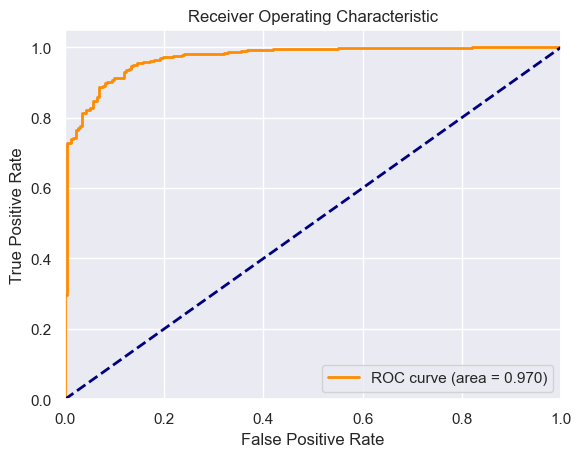

In [22]:
# Show the ROC curve
plt.figure()
plt.plot(fpr, tpr, color='darkorange', lw=2, label='ROC curve (area = %0.3f)' % roc_auc)
plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver Operating Characteristic')
plt.legend(loc='lower right')
plt.show()

20/20 [==============================] - 0s 15ms/step


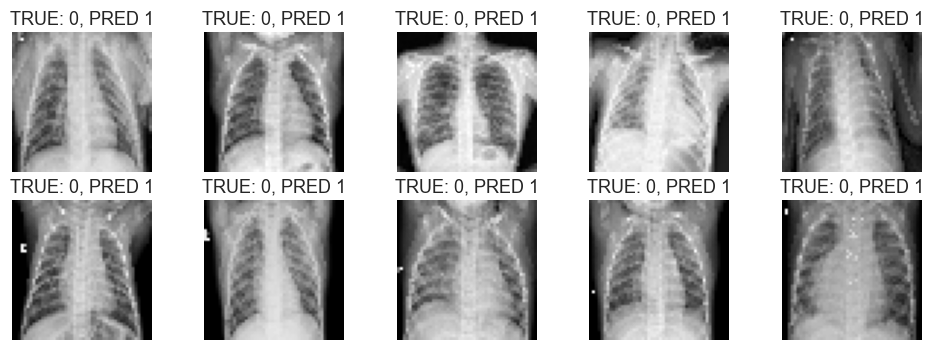

In [23]:
# Identify wrong predictions in the training set

y_test_pred = model.predict(X_test).argmax(axis=1)
idx_wrong = np.where(y_test_pred != y_test)[0] #positions of the wrongly classified data

num_wrong = len(idx_wrong)

# Show 10 wrong predictions the training set

fig, axs = plt.subplots(2,5,figsize=(12,4))

for i in range(10):
    
    ax = axs.ravel()[i]
    
    idx = idx_wrong[randrange(0, num_wrong)]
    
    ax.imshow(X_train[idx], cmap='gray')
    ax.set_title('TRUE: {}, PRED {}'.format(y_test[idx], y_test_pred[idx]), fontsize=13)
    ax.axis('off')